  # <center>**从决策树到随机森林**
  ## <center>*From DecisionTree to RandomForest*
    
  * * *
  
  ## <center>组员：黄宇轩 陈震 张玉鹏 吴宇迪

<center> **数据集介绍**
=============

* <font size=4 face="微软雅黑"> 当年泰坦尼克号的沉没造成了很多人的死亡，其中比较重要的一个因素是救生艇不足 </font>


* <font size=4 face="微软雅黑">尽管是否能活下来有运气的成分，但有些人群的存活概率确实相对更高（比如女性，孩子）</font>


* <font size=4 face="微软雅黑">训练集**给出一些乘客的个人信息以及存活状况**，要根据它**预测测试集里其他乘客的存活状况** </font>



    
# **流程**：

## <font size=4>1. 数据分析 </font>


## <font size=4>2. 预处理与特征提取和选择 </font>


## <font size=4>3. 分类器设计（决策树和随机森林） </font>


## <font size=4>4. 分类预测 </font>



In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import operator
import matplotlib.pyplot as plt 

# **查看数据集基本情况**

In [2]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# 先保存test_data的PassengerId以输出
test_Pid = test_data["PassengerId"]

train_data.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



# **数据集的特点：**
<font size=4 face="微软雅黑"> 1. 数据集比较小，训练集**891**个数据，测试集**418**个数据

<font size=4 face="微软雅黑"> 2. *Age*, *Cabin* 和 *Embarked* 列有不少空值需要处理

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# *Name*

* <font size=4  face="微软雅黑"> 名字看起来对是否生还没有作用，但是统计之后却发现**名字越长获救几率越大**


* <font size=4 face="微软雅黑"> 同样发现名字里的**称谓**对是否获救也有影响


* <font size=4  face="微软雅黑"> **创建** *NameLength* 和 *Name_Title* 新列


* <font size=4 face="微软雅黑"> 由于这些属性之间不存在大小关系，因此最后进行**独热编码**，每个可能的属性取值设一列



In [4]:

def names(train, test):
    for i in [train, test]:
       i['NameLength'] = i['Name'].apply(lambda x: len(x))
       i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
    print(train['Survived'].groupby(pd.qcut(train['NameLength'], 5)).mean())
    print(train['Survived'].groupby(train['Name_Title']).mean())
    good_cols = ['Name_Title' + '_' + i for i in train['Name_Title'].unique() if i in test['Name_Title'].unique()]
    train = pd.concat((train, pd.get_dummies(train['Name_Title'], prefix='Name_Title')[good_cols]), axis=1)
    test = pd.concat((test, pd.get_dummies(test['Name_Title'], prefix='Name_Title')[good_cols]), axis=1)
    del train['Name_Title']
    del test['Name_Title']
    return train, test
train_data, test_data = names(train_data, test_data)


NameLength
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64
Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64


## *PassengerId & Name & Ticket*

* <font size=4 face="微软雅黑"> 丢弃无用的 *PassengerId*  *Name*  *Ticket* 列 </font>


## *Sex*

* <font size=4 face="微软雅黑"> 把 *Sex* 中字符串变成整数，male设为1，female设为0 </font>


## *Cabin*

* <font size=4 face="微软雅黑">  *Cabin* 中缺失值太多，下图中发现该属性是否缺失对生还率影响较大，因此有值则填1，没值则填0 </font>

['male' 'female']


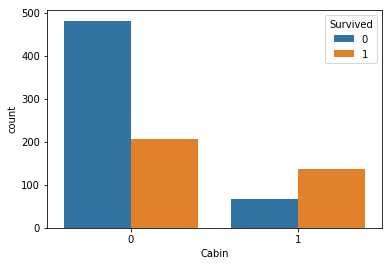

In [5]:
# 丢弃无用的 PassengerId Name Ticket列
train_data = train_data.drop(["PassengerId", "Name", "Ticket"], axis=1)
test_data = test_data.drop(["PassengerId", "Name", "Ticket"], axis=1)

# 对Sex进行处理，male为1，female为0
print(train_data["Sex"].unique())
train_data.loc[train_data["Sex"] == 'male', "Sex"] = 0  # 左边选行，右边选列
train_data.loc[train_data["Sex"] == 'female', "Sex"] = 1
test_data.loc[test_data["Sex"] == 'male', "Sex"] = 0
test_data.loc[test_data["Sex"] == 'female', "Sex"] = 1

# 对Cabin进行处理，缺失值太多，有值则填1，没值则填0 
train_data.loc[train_data['Cabin'].notnull(), 'Cabin'] = 1
train_data.loc[train_data['Cabin'].isnull(), 'Cabin'] = 0
test_data.loc[test_data['Cabin'].notnull(), 'Cabin'] = 1
test_data.loc[test_data['Cabin'].isnull(), 'Cabin'] = 0
sns.countplot(train_data['Cabin'], hue=train_data['Survived'])

# *Embarked*
* <font size=4 face="微软雅黑"> *Embarked* 为乘客登船城市，按理来说影响不大，但是从统计却看出，从C城登船的人生还率明显比其他城市高，猜测可能那里贵族比较多，因此也**把*Embarked* 中字符转为数字**


* <font size=4 face="微软雅黑"> 对于缺失值，*Embarked* 中只有一个，直接填**众数**S

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64
['S' 'C' 'Q' nan]


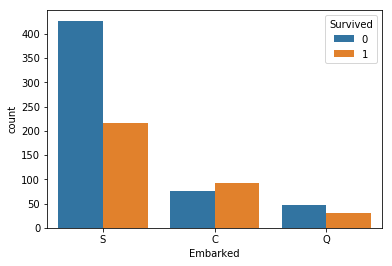

In [6]:
# 对Embarked进行处理，缺失值直接填S
print(train_data['Survived'].groupby(train_data['Embarked']).mean())
sns.countplot(train_data['Embarked'], hue=train_data['Survived'])
print(train_data["Embarked"].unique())
train_data["Embarked"] = train_data["Embarked"].fillna('S')
train_data.loc[train_data["Embarked"] == 'S', "Embarked"] = 0
train_data.loc[train_data["Embarked"] == 'C', "Embarked"] = 1
train_data.loc[train_data["Embarked"] == 'Q', "Embarked"] = 2
test_data["Embarked"] = test_data["Embarked"].fillna('S')
test_data.loc[test_data["Embarked"] == 'S', "Embarked"] = 0
test_data.loc[test_data["Embarked"] == 'C', "Embarked"] = 1
test_data.loc[test_data["Embarked"] == 'Q', "Embarked"] = 2


# *Age*
* <font size=4 face="微软雅黑"> 从下面的统计数据可以看出，*Age* 为空值的177个乘客，平均生还率比非空值的乘客小10%
    

* <font size=4 face="微软雅黑"> 因此**设一列 *Age_null* **来表示这个特性.
    

In [7]:
train_data['Survived'].groupby(train_data['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

# *Age*
*  <font size=4 face="微软雅黑"> 对 *Age* 缺失值的填充，由于缺失值不太多，因此**使用随机森林回归算法进行预测**，填充空值</font>

In [8]:
# 对Age缺失值的填充，由于缺失值不太多，因此使用随机森林回归算法进行预测
def setMissingAges(df):
    age_df = df[['Age', 'Parch', 'SibSp', 'Pclass', 'Cabin']]
    knownAge = age_df[df.Age.notnull()]
    unknownAge = age_df[df.Age.isnull()]
    y = knownAge.values[:, 0]
    X = knownAge.values[:, 1:]
    rfr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    # train the regressor
    rfr.fit(X, y)
    predictedAges = rfr.predict(unknownAge.values[:, 1:])
    df.loc[df.Age.isnull(), "Age"] = predictedAges
    return df

test_data.loc[test_data['Fare'].isnull(), 'Fare'] = train_data['Fare'].mean()

train_data['Survived'].groupby(train_data['Age'].isnull()).mean()
train_data['Age_Null_Flag'] = train_data['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_data['Age_Null_Flag'] = test_data['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)

train_data = setMissingAges(train_data)
test_data = setMissingAges(test_data)

# *SibSp & Parch*
* <font size=4 face="微软雅黑"> 分析发现*SibSp* 和*Parch* 变量对是否获救影响不大，因此将两个弱变量加起来合并成一个** *Fam_Size* **的强变量

In [9]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp'] + i['Parch']) == 0, 0,
                                 np.where((i['SibSp'] + i['Parch']) <= 3, 1, 2))
        del i['SibSp']
        del i['Parch']
    return train, test
train_data, test_data = fam_size(train_data, test_data)
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,NameLength,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Age_Null_Flag,Fam_Size
0,0,3,0,22.0,7.2500,0,0,23,1,0,0,0,0,0,0,0,0,1
1,1,1,1,38.0,71.2833,1,1,51,0,1,0,0,0,0,0,0,0,1
2,1,3,1,26.0,7.9250,0,0,22,0,0,1,0,0,0,0,0,0,0
3,1,1,1,35.0,53.1000,1,0,44,0,1,0,0,0,0,0,0,0,1
4,0,3,0,35.0,8.0500,0,0,24,1,0,0,0,0,0,0,0,0,0


# <center>CART决策树<center>

# 基尼指数

<font size = 4 face = "微软雅黑">CART决策树使用**基尼指数**来选择划分属性。基尼指数反映了从数据集D中随机抽取两个样本，其类别标记不一致的概率。
基尼指数的计算公式如下：

<font size = 4>$$ Gini(D)=\sum_{k=1}^{n}\sum_{k' \neq k}{p_k p_k'}=1-\sum_{k=1}^{n}{p_k}^{2} $$

In [10]:
def gini(y_train):
    cate_cnt = {}
    for item in y_train:
        if item not in cate_cnt.keys():
            cate_cnt[item] = 1.0
        else:
            cate_cnt[item] += 1
    sum_cnt = y_train.shape[0]
    result = 1.0
    for key, value in cate_cnt.items():
        p = value / sum_cnt
        result -= p * p
    return result

# 二叉划分

<font size = 4 face = "微软雅黑">根据CART决策树的规则，所有的结点都是**二叉**的。对于当前的每一个属性，都要考察样本在该属性上的**所有可能取值**，对于每个值，都将样本分为在该属性上取值**是该值**的和**不是该值**的，并计算该划分的*基尼指数*。选出基尼指数最小的取值即为该属性的基尼指数，对应的划分即为该属性的最佳划分。  
对于某个属性a来说，属性a的基尼指数定义为：

<font size = 4>$$ Gini\_index(D, a)=min\sum_{v=1}^{2}\frac{\left | D^{i_v} \right |}{\left | D \right |} Gini(D^{v})\ \ i=1,2,3...n $$

<font size = 4 face = "微软雅黑">在选择属性时，我们选择能使得基尼指数**最小**的属性进行划分。

In [11]:
def chooseCutpoint(x_train, y_train, i):
    value_list = [row[i] for index, row in x_train.iterrows()]

    value_list = set(value_list)
    best_gini_feature = 100
    gini_sum_feature = 0.0
    cutpoint = 0

    for value in value_list:
        gini_sum_feature = 0.0
        x, y = splitDataSet(x_train, y_train, i, value, True)
        g = gini(y)  # 左子节点的基尼系数
        gini_sum_feature += g * float(x.shape[0]) / x_train.shape[0]
        x, y = splitDataSet(x_train, y_train, i, value, False)
        g = gini(y)  # 右子节点的基尼系数
        gini_sum_feature += g * float(x.shape[0]) / x_train.shape[0]
        # 计算出按当前value作为切分点的时候，基尼系数
        if gini_sum_feature < best_gini_feature:
            best_gini_feature = gini_sum_feature
            cutpoint = value

    return best_gini_feature, cutpoint


def splitDataSet(x_train, y_train, i, value, flag):  # flag用于区分，是切分出属性值==value还是属性值!=value的子集
    temp = pd.concat([x_train, y_train], axis=1)
    if flag:
        temp = temp[temp[x_train.columns[i]] == value]
    else:
        temp = temp[temp[x_train.columns[i]] != value]
    temp = temp.drop(x_train.columns[i], axis=1)
    name = temp.columns[temp.shape[1] - 1]  # 获取最后一列的名字
    retx = temp.drop(name, axis=1)
    rety = temp[name]
    return retx, rety

<font size = 4 face = "微软雅黑">还有一种常用的方法是，在计算划分的基尼指数时，对于属性的所有的可能取值，从小到大在**相邻两点**间取一个**平均值**，将样本按**小于等于该值**和**大于该值**的方法划分。该方法适用于属性值有大小关系的情况。

In [12]:
def chooseCutpointCont(x_train, y_train, i):
    value_list = [row[i] for index, row in x_train.iterrows()]
    value_list = set(value_list)
    value_list = list(value_list)
    value_list.sort()

    best_gini_feature = 100
    gini_sum_feature = 0.0
    cutpoint = 0

    for k in range(len(value_list) - 1):
        value = (float(value_list[k]) + value_list[k + 1]) / 2
        # for value in value_list:
        gini_sum_feature = 0.0
        x, y = splitDataSet(x_train, y_train, i, value, True)
        g = gini(y)  # 左子节点的基尼系数
        gini_sum_feature += g * float(x.shape[0]) / x_train.shape[0]
        x, y = splitDataSet(x_train, y_train, i, value, False)
        g = gini(y)  # 右子节点的基尼系数
        gini_sum_feature += g * float(x.shape[0]) / x_train.shape[0]
        # 计算出按当前value作为切分点的时候，基尼系数
        if gini_sum_feature < best_gini_feature:
            best_gini_feature = gini_sum_feature
            cutpoint = value

    return best_gini_feature, cutpoint


def splitDataSetCont(x_train, y_train, i, value, flag):  # flag用于区分，是切分出属性值<=value还是属性值>value的子集
    temp = pd.concat([x_train, y_train], axis=1)
    if flag:
        temp = temp[temp[x_train.columns[i]] <= value]
    else:
        temp = temp[temp[x_train.columns[i]] > value]
    temp = temp.drop(x_train.columns[i], axis=1)
    name = temp.columns[temp.shape[1] - 1]  # 获取最后一列的名字
    retx = temp.drop(name, axis=1)
    rety = temp[name]
    return retx, rety

# 随机选择属性

<font size = 4 face = "微软雅黑">如果选择了 *random* 参数，则每次选择属性的时候，都会先随机剔除掉（最多）一半的属性，从剩下的属性中选出最佳的属性。

In [13]:
def chooseFeature(x_train, y_train, splitter):
    feature_cnt = x_train.shape[1]
    best_gini = 100  # 足够大了
    best_loc = -1
    best_cut = -1
    ran = set(range(feature_cnt))
    if splitter == "random":  # 随机剔除掉最多一半的属性
        arr = np.random.randint(0, feature_cnt, int(feature_cnt / 2))
        arr = set(arr)
        ran = ran - arr

    for i in ran:  # 对于选定的属性
        gini_sum, cutpoint = chooseCutpoint(x_train, y_train, i)  # 计算每个属性的最佳切分点以及最佳切分情况下的基尼系数
        if gini_sum < best_gini:
            best_gini = gini_sum
            best_loc = i
            best_cut = cutpoint
    return best_loc, best_cut

# <center>生成决策树</center>

# 限制最小可划分样本数
<font size = 4 face = "微软雅黑">*min_samples_split*参数用于设定当前结点的最小划分样本数。只有在结点中的样本个数大于*min_samples_split*参数时，该结点才会被继续划分成子结点，否则将直接使用**投票法**确定该结点的类别归属。

# 限制最大深度
<font size = 4 face = "微软雅黑">*max_depth*参数用于限制决策树的最大深度。当决策树的深度达到最大深度时，结点也将不再分裂，而是直接使用**投票法**确定该结点的类别归属。**限制最大深度有助于防止过拟合。**

In [14]:
def treeGen(x_train, y_train, values, cur_depth, splitter="best", max_depth=None, min_samples_split=2):
    attributes = x_train.columns
    cur = Node()
    # 类别完全相同，停止划分
    if y_train.value_counts().shape[0] == 1:
        cur.cate = y_train.iloc[0]
        cur.cnt = 0
        return cur

    flag = True
    for attr in attributes:
        if x_train[attr].value_counts().shape[0] != 1:
            flag = False
            break
    # 属性集为空或在所有属性上的值都相同或深度达到了最大深度
    temp = set(attributes)
    # print(len(temp))
    if len(temp) == 0 or flag or (max_depth is not None and cur_depth >= max_depth):
        cur.cate = vote(y_train)
        cur.cnt = 0
        return cur

    # 找出最佳属性
    best_loc, value = chooseFeature(x_train, y_train, splitter)
    cur.attr = attributes[best_loc]
    cur.attr_value = value

    x, y = splitDataSet(x_train, y_train, best_loc, value, True)
    if x.shape[0] <= min_samples_split:  # 如果样本数太少则不继续划分
        child = Node()
        child.cate = vote(y_train)
        child.cnt = 0
        cur.cnt += 1
        cur.children[value] = child
    else:
        child = treeGen(x, y, values, cur_depth + 1, splitter, max_depth)
        cur.cnt += 1
        cur.children[value] = child

    x, y = splitDataSet(x_train, y_train, best_loc, value, False)
    if x.shape[0] <= min_samples_split:  # 如果样本数太少则不继续划分
        child = Node()
        child.cate = vote(y_train)
        child.cnt = 0
        cur.cnt += 1
        cur.children[-1] = child
    else:
        child = treeGen(x, y, values, cur_depth + 1, splitter, max_depth)
        cur.cnt += 1
        cur.children[-1] = child

    return cur

# 投票法

In [15]:
def vote(y_train):
    cate_cnt = {}
    for item in y_train:
        if item not in cate_cnt.keys():
            cate_cnt[item] = 1.0
        else:
            cate_cnt[item] += 1
    sorted_cnt = sorted(cate_cnt.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_cnt[0][0]

# 生成属性取值列表

In [16]:
def valueListGen(x_train):
    values = {}
    for i in range(x_train.shape[1]):
        value_list = [row[i] for index, row in x_train.iterrows()]
        value_list = set(value_list)
        values[x_train.columns[i]] = value_list
    return values

# <center>数据结构定义</center>

# 决策树结点

In [17]:
class Node(object):
    cnt = 0
    children = {}
    attr = ""
    attr_value = -1
    cate = 2  # 2 is invalid

    def __init__(self):
        self.cnt = 0
        self.children = {}
        self.attr = ""
        self.attr_value = -1
        self.cate = 2

# 决策树

<font size = 4 face = "微软雅黑">决策树的基本操作接口有 *fit* 和 *predict* ，和sklearn中的决策树用法保持一致。

In [18]:
class DecisionTree(object):
    root = Node()
    values = []

    def __init__(self):
        self.root = Node()
        self.values = []

    def fit(self, x_train, y_train, splitter="random", max_depth=None, min_samples_split=2):
        self.values = valueListGen(x_train)
        self.root = treeGen(x_train, y_train, self.values, 0, splitter, max_depth, min_samples_split)

    def predict_one(self, row):
        cur = self.root
        while cur.cnt != 0:
            temp = row[cur.attr]
            if temp == cur.attr_value:
                cur = cur.children[temp]
            else:
                cur = cur.children[-1]
        return cur.cate
    
    def predict(self, x_test):
        result = []
        for index, row in x_test.iterrows():
            cate = self.predict_one(row)
            result.append(cate)
        return result    

# **这里对决策树测试一下 各个参数说明 图表等等**

# **以下是随机森林**

In [19]:
def bootstrap(data_X, data_y):
    """不放回选取n个（n取样本个数）作为新样本返回"""
    n = len(data_X)
    idx = np.random.randint(n, size=n)  # 产生0到n-1的随机列表
    sample_X = data_X.iloc[idx]
    sample_y = data_y[idx]
    return sample_X, sample_y


class MyRandomForestClassifier:
    def __init__(self, n_estimators=10, oob_score=False):
        self.n_estimators = n_estimators  # integer 森林里树的个数
        self.oob_score = oob_score  # bool 是否用袋外样本来估计精度
        self.trees = []  # 决策树集合

    def fit(self, X, y):
        """根据训练集(X, y)建随机森林"""
        # 先随机有放回的抽样，构造得到n_estimators颗树
        for i in range(self.n_estimators):
            (subsampleX, subsample_y) = bootstrap(X, y)
            # (subsampleX, subsample_y) = (X, y)
            #tree = DecisionTree()
            #tree.fit(subsampleX, subsample_y, splitter="random", min_samples_split=10)
            tree = DecisionTreeClassifier(splitter="random", min_samples_split=10, min_samples_leaf=1,
                                         max_features='auto')
            tree.fit(subsampleX, subsample_y)
            self.trees.append(tree)

    def predict(self, X):
        """预测X属于哪类"""
        cnt = np.zeros(len(X), dtype=np.int32)
        for tree in self.trees:
            y = np.array(tree.predict(X))
            cnt = np.add(cnt, y)
        i = 0
        while i < len(cnt):
            if cnt[i] > self.n_estimators // 2:
                cnt[i] = 1
            else:
                cnt[i] = 0
            i = i + 1
        return cnt


# **以下用随机森林进行预测**

In [20]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]

random_forest = MyRandomForestClassifier(n_estimators=800)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(test_data)

submission = pd.DataFrame({
        "PassengerId": test_Pid,#test_data["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)